In [1]:
from operator import itemgetter
import os
import re
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import namedtuple
import csv
from itertools import repeat
import numpy as np
import math
import scipy.interpolate as inter
from statistics import mean

In [3]:
def read_verification_log(file_name):
    '''
    Read generated verification data from a csv file.

    Return: tuple of recorded errors and accuracies
    '''
    Errors = []
    Accs = []
    VerificationRecord = namedtuple('VerificationRecord', 'opt_error, accuracy')
    
    with open(file_name) as csvfile:
        readCSV = map(VerificationRecord._make, csv.reader(csvfile, delimiter=','))
        for row in readCSV:
            Errors.append(float(row.opt_error))
            Accs.append(float(row.accuracy))
    return (Errors, Accs)

    
# Smoothing as in TB: https://github.com/tensorflow/tensorflow/blob/905662a1c047f314ad295e27d2e2a00b4aa51e90/tensorflow/tensorboard/components/vz_line_chart/vz-line-chart.ts#L432
# Assume that we only have finite numbers.
def smooth_data(data, smoothing_weight=0.6):
    factor = ((1000** smoothing_weight) - 1) / 999
    kernel_radius = math.floor(len(data) * factor / 2)
    
    Y_smoothed = []
    
    for i, d in enumerate(data):
        actual_kernel_radius = min(kernel_radius, i, len(data) - i - 1)
        start = i - actual_kernel_radius
        end = i + actual_kernel_radius + 1
        
        Y_smoothed.append(mean(data[start:end]))
    
    return Y_smoothed


def plot_progress(X, Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(X, Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    #plt.legend(['test'], loc='upper right')
    plt.show()

    
def interpolate_spline(X,Y, spacing, smoothing=0.0):
    s1 = inter.UnivariateSpline(X, Y, s=smoothing)
    xNew = np.linspace(min(X),max(X),spacing)
    return xNew, s1(xNew)


def monotone_progress(Accs):
    maximum = 0
    monotoneValues = []
    for acc in Accs:
        maximum = maximum if acc < maximum else acc
        monotoneValues.append(maximum)
    return monotoneValues
        

In [4]:
from pathlib import Path

RESULT_DIR = Path("../benchmark_results")

def plot_progress_3(x1, y1, title1,
                    x2, y2, title2,
                    x3, y3, title3,
                    ymax=1, ymin=0, ylabel=''):

    min_len = min(len(x1), len(x2), len(x3))
    # x1 = x1[:min_len]
    # x2 = x2[:min_len]
    # x3 = x3[:min_len]
    # y1 = y1[:min_len]
    # y2 = y2[:min_len]
    # y3 = y3[:min_len]

    fig, axs = plt.subplots(1,3,figsize=(15,5))
    xlabel = 'Communication round'

    axs[0].set_title(title1)
    axs[0].set_ylabel(ylabel)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylim(ymin, ymax)

    axs[0].plot(x1, y1, 'c')

    axs[1].set_title(title2)
    axs[1].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylim(ymin, ymax)

    axs[1].plot(x2, y2, 'm')
    
    axs[2].set_title(title3)
    axs[2].set_ylabel(ylabel)
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylim(ymin, ymax)

    axs[2].plot(x3, y3, 'y')


def plot_on_plots(x1, y1,
                  x2, y2,
                  x3, y3, title,
                  ymax=1, ymin=0, ylabel=''):

    min_len = min(len(x1), len(x2), len(x3))
    x1 = x1[:min_len]
    x2 = x2[:min_len]
    x3 = x3[:min_len]
    y1 = y1[:min_len]
    y2 = y2[:min_len]
    y3 = y3[:min_len]

    plt.ylim(ymin, ymax)
    var1, = plt.plot(x2, y2, 'k', label='variant 1')
    var0, = plt.plot(x1, y1, 'r', label='variant 0')
    var2, = plt.plot(x3, y3, 'y', label='variant 2')
    var0Monotone = plt.plot(x2, monotone_progress(y2), color='lightgray', alpha=0.5)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    plt.legend(handles=[var0, var1, var2])

    pdf_path = RESULT_DIR / ('plot_' + title.replace(' ', '_') + '.pdf')
    plt.savefig(pdf_path, format='pdf')    
    plt.show()

In [5]:
def simple_plot_progress(Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    plt.show()
    
def plot_overlap(*yls, ymin=0.0, ymax=1.0, file_name=None, title=None):

    fig = plt.figure(figsize=(5,4), dpi=300)
    #min_len = min([len(y) for y in ys])
    for y in yls[0]:
        #y = y[:min_len]
        y_maxes = y #monotone_progress(y)
        plt.plot(y_maxes, alpha=0.5)
    
    if ymax == None:
        ymax = max([max(y) for y in yls[0]])
    
    plt.ylim(ymin, ymax)

    plt.ylabel("Accuracy")
    plt.xlabel("Communication rounds")
    plt.legend(yls[1], loc='lower right')
    
    if title:
        plt.title(title)
    
    if file_name:
        plt.savefig(file_name, format='pdf', bbox_inches="tight")
    
    plt.show(fig)

In [6]:
def extract_h(string):
    h_match = re.search(r'(?<=_h)\d+(.\d+)*', string)
    h = h_match.group(0)
    h = float(h)
    return h


def choose_logs(score_logs, hs):
    log_h = map(extract_h, score_logs)
    log_and_h = zip(score_logs, log_h)
    choosen_logs = filter(lambda log_h: log_h[1] in hs, log_and_h)
        
    return list(zip(*choosen_logs))[0]


def remove_duplicate_h_logs(sorted_logs):
    log_h = map(extract_h, sorted_logs)
    log_and_h = zip(sorted_logs, log_h)    
    
    seen_h = set()
    logs = []
    for log, h in log_and_h:
        if h not in seen_h:
            seen_h.add(h)
            logs.append(log)
            
    return logs

def plot_score_logs(score_logs, title=None, file_name=None):
    accs = [read_verification_log(file)[1][:1000] for file in score_logs]
    max_acc = [max(a) for a in accs]
    cs_es = ['$h={}$, max: ${:.3}\%$'.format(extract_h(file), ma*100) for file, ma in zip(score_logs, max_acc)]
    accs_labels = (accs, cs_es)

    plot_overlap(*accs_labels, ymin=0.9, ymax=0.985, file_name=file_name, title=title)

In [7]:
FSVRG_DIR = RESULT_DIR / 'fsvrg'
score_logs = glob.glob(str(FSVRG_DIR / "*.csv"))

sorted_logs = sorted(score_logs, key=extract_h)

for log_name in sorted_logs:
    print(log_name)

../benchmark_results/fsvrg/score_log_id1526976556000_MNIST-non-iid_h1.csv
../benchmark_results/fsvrg/score_log_id1523375555000_MNIST-non-iid_h1.csv
../benchmark_results/fsvrg/score_log_id1525274512000_MNIST-non-iid_h2.csv
../benchmark_results/fsvrg/score_log_id1525361301000_MNIST-non-iid_h2.5.csv
../benchmark_results/fsvrg/score_log_id1526190708000_MNIST-non-iid_h3.csv
../benchmark_results/fsvrg/score_log_id1525623709000_MNIST-non-iid_h4.csv
../benchmark_results/fsvrg/score_log_id1527949889000_MNIST-non-iid_h5.csv
../benchmark_results/fsvrg/score_log_id1525703738000_MNIST-non-iid_h5.csv
../benchmark_results/fsvrg/score_log_id1525066939000_MNIST-non-iid_h15.csv
../benchmark_results/fsvrg/score_log_id1525011838000_MNIST-non-iid_h30.csv
../benchmark_results/fsvrg/score_log_id1524956808000_MNIST-non-iid_h45.csv
../benchmark_results/fsvrg/score_log_id1524900516000_MNIST-non-iid_h60.csv
../benchmark_results/fsvrg/score_log_id1524843533000_MNIST-non-iid_h75.csv
../benchmark_results/fsvrg/scor

In [8]:
hs = [1, 2, 2.5, 4, 5]
filtered_logs = choose_logs(sorted_logs, hs)
plot_logs = remove_duplicate_h_logs(filtered_logs)

for log in plot_logs:
    print(log)

../benchmark_results/fsvrg/score_log_id1526976556000_MNIST-non-iid_h1.csv
../benchmark_results/fsvrg/score_log_id1525274512000_MNIST-non-iid_h2.csv
../benchmark_results/fsvrg/score_log_id1525361301000_MNIST-non-iid_h2.5.csv
../benchmark_results/fsvrg/score_log_id1525623709000_MNIST-non-iid_h4.csv
../benchmark_results/fsvrg/score_log_id1527949889000_MNIST-non-iid_h5.csv


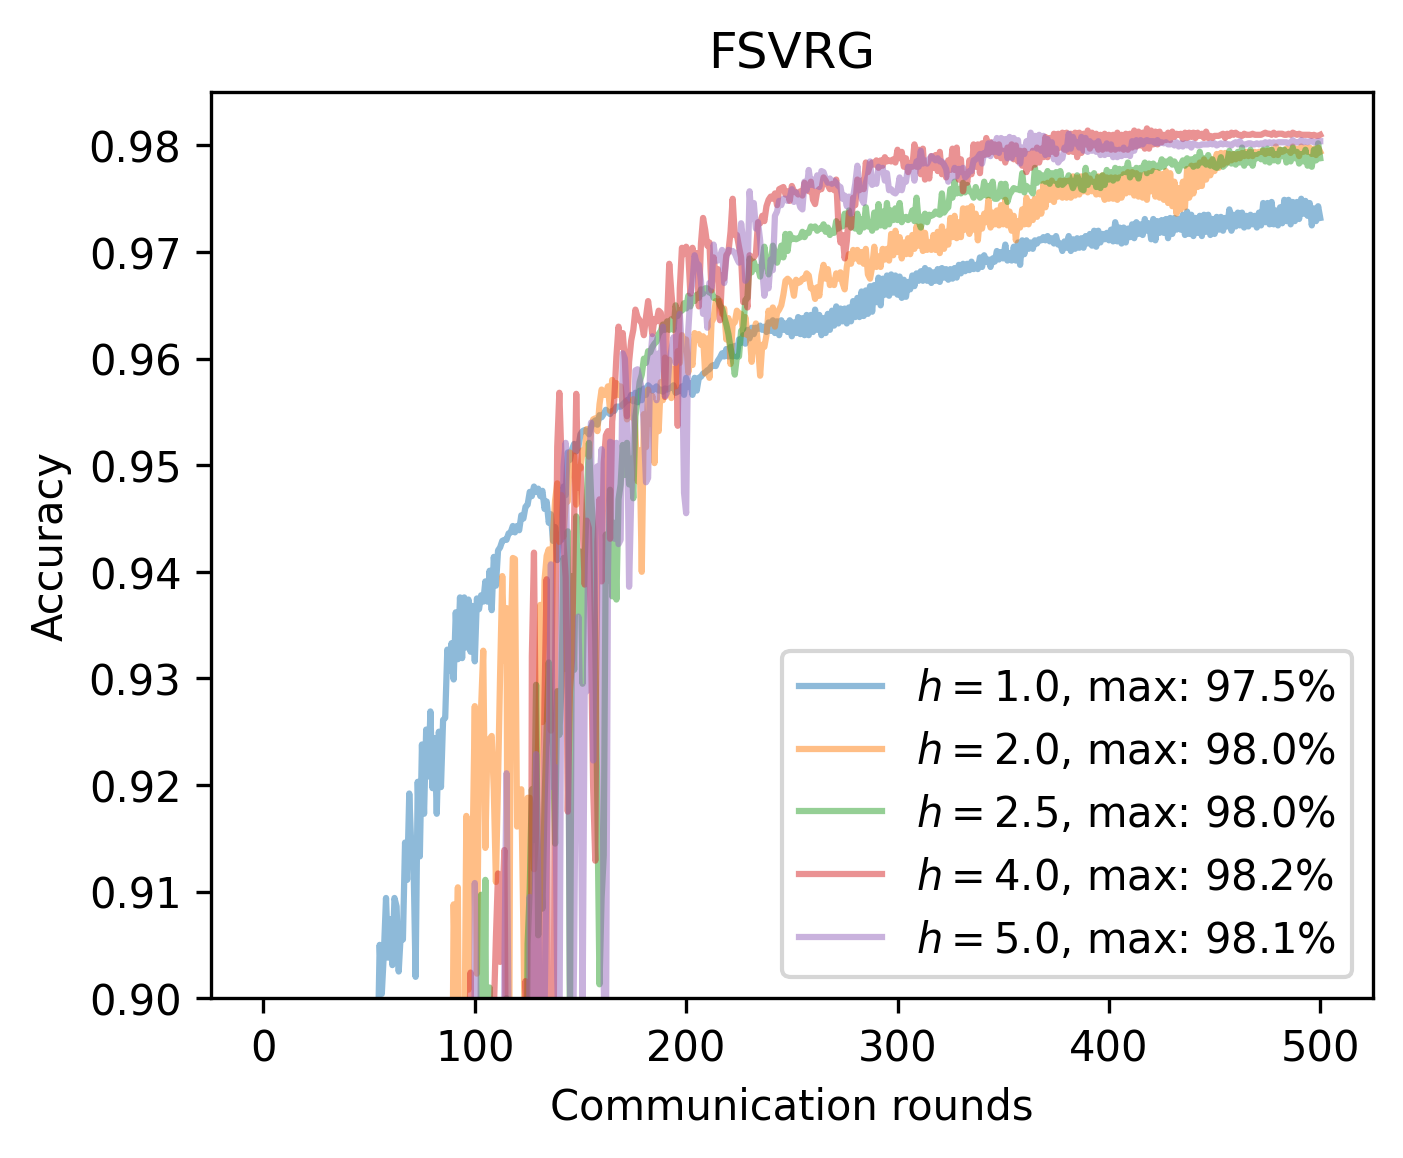

In [9]:
pdf_path = FSVRG_DIR / "plot_fsvrg.pdf"
plot_score_logs(plot_logs, 'FSVRG',pdf_path)

In [10]:
for log in plot_logs:
    print(log)
    acc = read_verification_log(log)[1]
    print("First 400 max acc:", max(acc[:400]))
    print("First 500 max acc:", max(acc[:500]))

../benchmark_results/fsvrg/score_log_id1526976556000_MNIST-non-iid_h1.csv
First 400 max acc: 0.972
First 500 max acc: 0.975
../benchmark_results/fsvrg/score_log_id1525274512000_MNIST-non-iid_h2.csv
First 400 max acc: 0.9772
First 500 max acc: 0.9799
../benchmark_results/fsvrg/score_log_id1525361301000_MNIST-non-iid_h2.5.csv
First 400 max acc: 0.9779
First 500 max acc: 0.9802
../benchmark_results/fsvrg/score_log_id1525623709000_MNIST-non-iid_h4.csv
First 400 max acc: 0.9814
First 500 max acc: 0.9816
../benchmark_results/fsvrg/score_log_id1527949889000_MNIST-non-iid_h5.csv
First 400 max acc: 0.9812
First 500 max acc: 0.9812
